In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [3]:
import gc
gc.collect()

27

In [4]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Split Train Test Datasets

In [5]:
X = df.iloc[:,1:29]
Y = df.iloc[:, 30]

X = normalize(X)
y = np.array(Y)
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (227845, 28)
y_train shape: (227845,)
X_test shape: (56962, 28)
y_test shape: (56962,)


## Torch Dataloaders

In [6]:
trainloader = DataLoader(
    TensorDataset(
        torch.from_numpy(X_train),
        torch.from_numpy(y_train)
    ),
    batch_size=len(X_train), shuffle=True
    
)

testloader = DataLoader(
    TensorDataset(
        torch.from_numpy(X_test),
        torch.from_numpy(y_test)
    ),
    batch_size=len(X_test), shuffle=False
    
)

dataloaders = {
    "train": trainloader,
    "validation": testloader
}

## Model Declaration

In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28, 340)
        self.fc2 = nn.Linear(340, 220)
        self.fc3 = nn.Linear(220, 200)
        self.fc4 = nn.Linear(200, 70)
        self.fc5 = nn.Linear(70, 10)
        self.fc6 = nn.Linear(10, 2)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.dropout(F.relu(self.fc5(x)))
        x = F.log_softmax(self.fc6(x), dim=1)
        
        return x

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [8]:
model.cuda(device)

Classifier(
  (fc1): Linear(in_features=28, out_features=340, bias=True)
  (fc2): Linear(in_features=340, out_features=220, bias=True)
  (fc3): Linear(in_features=220, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=70, bias=True)
  (fc5): Linear(in_features=70, out_features=10, bias=True)
  (fc6): Linear(in_features=10, out_features=2, bias=True)
  (dropout): Dropout(p=0.2)
)

## Prediction output function

In [15]:
def predict(model, inputs):
    output = model(inputs)
    return torch.argmax(output,1)

## Training Neural Network

In [20]:
from torch.autograd import Variable

loss1 = []
train_acc = []

Epoch = 20

for epoch in range(Epoch):
    print('---------------------------------------------------------')
    acc = 0
    train_acc1=0
    
    for i, (features, labels) in enumerate(trainloader):
        
        #load dataset
        features = Variable(features).to(device)
        labels = Variable(labels).to(device)
        
        optimizer.zero_grad() ## set grads to 0
        features = features.float()
        
        #Get model training predictions
        outputs = model(features)
        
        #Estimate loss value
        loss = criterion(outputs, labels.long())
        
        #Perform backpropragation
        loss.backward()
        
        # Start over moving along solutions space
        optimizer.step()
        
        # After training epoch, check accuracy
        if (i+1) % len(trainloader) == 0:
            y_pred = predict(
                model, 
                torch.from_numpy(X_train).float().to(device)
            )
            acc = np.mean(y_train == np.array(y_pred.cpu()))
            
            train_acc1 = acc/len(trainloader)
            train_acc.append(train_acc1)
            loss1.append(loss.data)
            
            print (f'Epoch [{epoch+1}/{Epoch}], Iter [{i+1}] Loss: {loss.data:.4f} Training Accuracy: {train_acc1:.4f}')
        
        

---------------------------------------------------------
Epoch [1/40], Iter [1] Loss: 0.0569 Training Accuracy: 0.9967
---------------------------------------------------------
Epoch [2/40], Iter [1] Loss: 0.0705 Training Accuracy: 0.9966
---------------------------------------------------------
Epoch [3/40], Iter [1] Loss: 0.0761 Training Accuracy: 0.9967
---------------------------------------------------------
Epoch [4/40], Iter [1] Loss: 0.0727 Training Accuracy: 0.9967
---------------------------------------------------------
Epoch [5/40], Iter [1] Loss: 0.0699 Training Accuracy: 0.9966
---------------------------------------------------------
Epoch [6/40], Iter [1] Loss: 0.0606 Training Accuracy: 0.9966
---------------------------------------------------------
Epoch [7/40], Iter [1] Loss: 0.0520 Training Accuracy: 0.9965
---------------------------------------------------------
Epoch [8/40], Iter [1] Loss: 0.0450 Training Accuracy: 0.9967
----------------------------------------

## Plot accuracies and loss function

In [26]:
np_loss = np.array(loss1[0].cpu())

for i in range(len(loss1)):
    np_loss = np.append(np_loss, loss1[i].cpu())
    
np_acc = train_acc[0]
for i in range(len(train_acc)):
    np_acc = np.append(np_acc, train_acc[i])

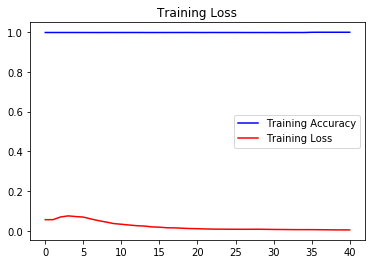

In [27]:
%matplotlib inline
plt.plot(np_acc, color="blue", label="Training Accuracy")
plt.plot(np_loss, color="red", label="Training Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

## Evaluate performance in Test dataset

In [31]:
y_pred = predict(model, torch.from_numpy(X_test).float().to(device))
acc = np.mean(y_test == np.array(y_pred.cpu()))
print('Test accuracy: ', acc)

Test accuracy:  0.998156665847407


## Precision / Recall / F1 Scores using sklearn

In [34]:
from sklearn.metrics import classification_report
target_names = ['Class 0', 'Class 1']
print(classification_report(y_test, np.array(y_pred.cpu()), target_names=target_names))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     56876
     Class 1       0.00      0.00      0.00        86

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



Best measure to use for evaluating the credit default model performance is precision and recall of minoritary class. This notebook is just to show the use of pytorch and GPU tensor in classification model